In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [2]:
df = pd.read_csv(r"D:\Work_Station\DeeplearningBasics\src\processed_dataset.csv")
df.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,-0.953538,0,4,-0.104090,-0.892284,3,4.024953,4,1.683039,4.016394,-0.739109,-1.419814,0,1
1,-1.118963,0,3,-0.846005,-0.892284,2,-1.359209,1,0.044782,-0.684829,-0.996863,-2.549975,1,0
2,-0.457264,0,3,-0.844065,-0.397517,0,-0.646600,3,0.625557,3.443074,-0.739109,0.047412,0,1
3,-0.788113,0,1,-0.007039,-0.892284,3,4.024953,3,1.417829,3.443074,-0.996863,0.840507,0,1
4,-0.622689,1,4,-0.176371,-0.727362,3,4.024953,3,1.095549,4.475050,-0.481354,-0.924130,0,1


In [6]:
df.shape

(45000, 14)

In [9]:
X = np.array(df.iloc[:,:-1])
Y = np.array(df.iloc[:,-1])

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5, random_state = 42)

## Dataset Object Class

In [56]:
#Creating Dataset Object
class dataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype = torch.float32).to(device)
        self.Y = torch.tensor(Y, dtype = torch.float32).to(device)

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index], self.Y[index]

In [57]:
training_data = dataset(X_train, y_train)
validation_data = dataset(X_val, y_val)
testing_data = dataset(X_test, y_test)

## Data Loader

- To create a [batch size] of the data we create DataLoader
- It is an object that we use to do the for loop during each epoch, to loop through the specific amount of batches

In [58]:
batch_size = 32 #For rows inside the DataLoader

train_dataloader = DataLoader(training_data, batch_size = batch_size, shuffle = True)
validation_dataloader = DataLoader(validation_data, batch_size = batch_size, shuffle = True)
test_dataloader = DataLoader(testing_data, batch_size = batch_size, shuffle = True)

## Building Model

In [59]:
Hidden_Neurons = 64

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel,self).__init__()

        self.input_layer = nn.Linear(X.shape[1], Hidden_Neurons)
        self.linear = nn.Linear(Hidden_Neurons, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.input_layer(x)
        x = self.linear(x)
        x = self.sigmoid(x)

        return x
    
model = MyModel().to(device)

In [60]:
summary(model, (X.shape[1], ))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]             896
            Linear-2                    [-1, 1]              65
           Sigmoid-3                    [-1, 1]               0
Total params: 961
Trainable params: 961
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


## Loss Function

In [66]:
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum = 0) #1e-3

In [67]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

epochs = 10

for epoch in range(epochs):
    total_acc_train = 0
    total_loss_train = 0
    total_samples_train = 0

    model.train()  # Training mode
    for data in train_dataloader:
        inputs, labels = data

        prediction = model(inputs).squeeze(1)
        batch_loss = criterion(prediction, labels)

        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()

        total_loss_train += batch_loss.item()

        # Number of correct predictions in this batch
        acc = ((prediction.round() == labels).sum().item())
        total_acc_train += acc
        total_samples_train += labels.size(0)

    avg_train_loss = total_loss_train / len(train_dataloader)
    avg_train_acc = total_acc_train / total_samples_train

    total_loss_train_plot.append(avg_train_loss)
    total_acc_train_plot.append(avg_train_acc)

    # Validation
    model.eval()  # Evaluation mode
    total_acc_validation = 0
    total_loss_validation = 0
    total_samples_validation = 0

    with torch.no_grad():
        for data in validation_dataloader:
            inputs, labels = data
            prediction = model(inputs).squeeze(1)
            batch_loss = criterion(prediction, labels)

            total_loss_validation += batch_loss.item()

            acc = ((prediction.round() == labels).sum().item())
            total_acc_validation += acc
            total_samples_validation += labels.size(0)

    avg_val_loss = total_loss_validation / len(validation_dataloader)
    avg_val_acc = total_acc_validation / total_samples_validation

    total_loss_validation_plot.append(avg_val_loss)
    total_acc_validation_plot.append(avg_val_acc)

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {avg_train_acc:.4f}")
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {avg_val_acc:.4f}")
    print("--------------------------------------------------")


Epoch 1/10
Train Loss: 0.2310, Train Accuracy: 0.8902
Validation Loss: 0.2354, Validation Accuracy: 0.8886
--------------------------------------------------
Epoch 2/10
Train Loss: 0.2304, Train Accuracy: 0.8905
Validation Loss: 0.2353, Validation Accuracy: 0.8895
--------------------------------------------------
Epoch 3/10
Train Loss: 0.2303, Train Accuracy: 0.8913
Validation Loss: 0.2352, Validation Accuracy: 0.8893
--------------------------------------------------
Epoch 4/10
Train Loss: 0.2301, Train Accuracy: 0.8914
Validation Loss: 0.2353, Validation Accuracy: 0.8896
--------------------------------------------------
Epoch 5/10
Train Loss: 0.2300, Train Accuracy: 0.8913
Validation Loss: 0.2353, Validation Accuracy: 0.8899
--------------------------------------------------
Epoch 6/10
Train Loss: 0.2301, Train Accuracy: 0.8919
Validation Loss: 0.2352, Validation Accuracy: 0.8890
--------------------------------------------------
Epoch 7/10
Train Loss: 0.2299, Train Accuracy: 0.891

## Testing

In [68]:
with torch.no_grad():
    total_acc_test = 0
    total_loss_test = 0

    for data in test_dataloader:
        inputs, labels = data
        prediction = model(inputs).squeeze(1)
        batch_loss = criterion(prediction, labels)
        total_loss_test += batch_loss.item()
        acc = ((prediction).round() == labels).sum().item()
        total_acc_test += acc


print(f"Test Loss: {round(total_loss_test / len(test_dataloader), 4)}, Test Accuracy: {round(total_acc_test / len(testing_data), 4)}")

Test Loss: 0.2347, Test Accuracy: 0.8881


## Visualization

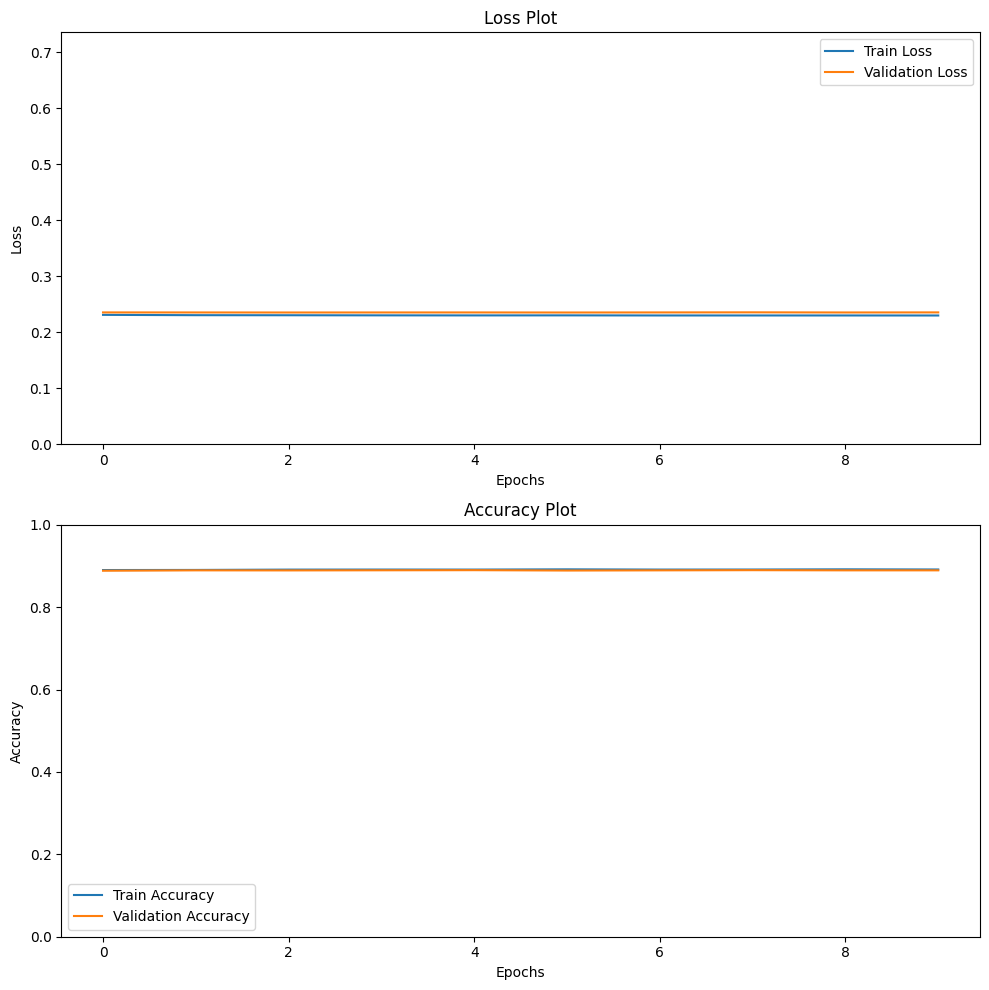

In [69]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

# Loss plot
axs[0].plot(total_loss_train_plot, label='Train Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Loss Plot')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_ylim(0, max(max(total_loss_train_plot), max(total_loss_validation_plot)) + 0.5)
axs[0].legend()


# Accuracy plot
axs[1].plot(total_acc_train_plot, label='Train Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title('Accuracy Plot')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim(0, 1)
axs[1].legend()


plt.tight_layout()
plt.show()
